#Les bibliothèques

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout,BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import TensorBoard

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from keras.utils import np_utils
import itertools
import os

from PIL import Image
from os import listdir
from os.path import isfile, join
import cv2
import os
from pathlib import Path
from os.path import basename

Using TensorFlow backend.


# Préparation des données

In [ ]:
def getFrame(sec):
    dir=listdir('/content/drive/My Drive/Data')
    for i in range(len(dir)):

      dd=os.path.join('/content/drive/My Drive/Data', dir[i])
      vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
      hasFrames,image = vidcap.read()
      
      if hasFrames:

         cv2.imwrite(str(x)+'/'+label+str(count)+".jpg", image)     # save frame as JPG file
    return hasFrames

mypath = "/content/drive/My Drive/face_dataset/video_input"

videosFiles = [ f for f in listdir(mypath) if isfile(join(mypath,f)) and (f.endswith(("mp4")) or f.endswith(("vip"))) ]

count=1
for vid in videosFiles:
    y=list()
    label,extent=os.path.splitext(vid)
    y.append(label)
    vidcap = cv2.VideoCapture(join(mypath,vid)) 
    vidcap.set(cv2.CAP_PROP_FRAME_WIDTH, 255)
    vidcap.set(cv2.CAP_PROP_FRAME_HEIGHT, 255)
    try:

      if not os.path.exists('/content/drive/My Drive/Data'+'/'+label): 

		       os.makedirs('/content/drive/My Drive/Data'+'/'+label) 

    except OSError: 
         
	    print ('Error: Creating directory of data')
    dd=os.path.join('/content/drive/My Drive/Data',label)
    x=Path(dd)

    sec = 0
    frameRate =0.2#//it will capture image in each 2 second
    success = getFrame(sec)
    while success:
      count = count + 1
      sec = sec + frameRate
      sec = round(sec, 2)
      success = getFrame(sec)
print('Done!!')

Done!!


In [ ]:
pip install split_folders

In [ ]:
import split_folders

split_folders.ratio('/content/drive/My Drive/Data', output="/content/drive/My Drive/split", seed=1337, ratio=(.9,.1))

Copying files: 751 files [08:16,  1.51 files/s]


In [ ]:
pip install mtcnn


#Prétraitement+Détection

In [ ]:
from mtcnn.mtcnn import MTCNN
from PIL import ImageOps,ImageFilter
def extract_face(filename, required_size=(160,160)):
    # Avant_détection
    image = Image.open(filename)
    image=image.convert('RGB')
    pixels = np.asarray(image)
    detector = MTCNN()

    results = detector.detect_faces(pixels)
    x1, y1, width, height = results[0]['box']
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    face = pixels[y1:y2, x1:x2]
    # Après_détection
    image = Image.fromarray(face)
    #image=ImageOps.autocontrast(image, cutoff=0, ignore=None)
    image=image.convert('L')
    image=ImageOps.autocontrast(image, cutoff=0, ignore=None)
    image = image.resize(required_size) 

    face_array = np.asarray(image)
    

    return face_array

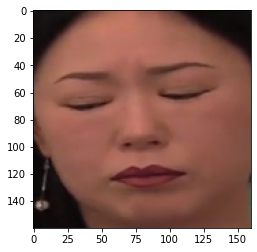

In [ ]:
fc=extract_face('/content/drive/My Drive/Data/yousra/yousra600.jpg')

plt.imshow(fc)

In [ ]:
def load_face(dir):
    faces = list()
    for filename in os.listdir(dir):
        path = dir + filename
        face = extract_face(path)
        faces.append(face)
    return faces

def load_dataset(dir):
    # list for faces and labels
    X, y = list(), list()
    for subdir in os.listdir(dir):
        path = dir + subdir + '/'
        faces = load_face(path)
        labels = [subdir for i in range(len(faces))]
        print("loaded %d sample for class: %s" % (len(faces),subdir) ) # print progress
        X.extend(faces)
        y.extend(labels)
    return np.asarray(X), np.asarray(y)

#Téléchargement des données

In [ ]:
trainX, trainy = load_dataset('/content/drive/My Drive/split/train/')
print(trainX.shape, trainy.shape)
testX, testy = load_dataset('/content/drive/My Drive/split/val/')
print(testX.shape, testy.shape)

np.savez_compressed('/content/drive/My Drive/split/Faces_dataset11.npz', trainX, trainy, testX, testy)

loaded 45 sample for class: alix
loaded 45 sample for class: wissal
loaded 45 sample for class: salah
loaded 45 sample for class: oumaima
loaded 45 sample for class: amina
loaded 45 sample for class: ilham
loaded 45 sample for class: sara
loaded 45 sample for class: Locas
loaded 45 sample for class: jenniffer
loaded 45 sample for class: sahar
loaded 45 sample for class: alan
loaded 45 sample for class: yousra
loaded 45 sample for class: soukaina
loaded 45 sample for class: idriss
loaded 45 sample for class: jihane
(675, 160, 160, 3) (675,)
loaded 5 sample for class: alix
loaded 5 sample for class: wissal
loaded 5 sample for class: salah
loaded 5 sample for class: oumaima
loaded 5 sample for class: amina
loaded 5 sample for class: ilham
loaded 5 sample for class: sara
loaded 5 sample for class: Locas
loaded 5 sample for class: jenniffer
loaded 5 sample for class: sahar
loaded 5 sample for class: alan
loaded 5 sample for class: yousra
loaded 5 sample for class: soukaina
loaded 6 sample f

# Mon_modèle


In [ ]:
import numpy as np
data = np.load('/content/drive/My Drive/split/Faces_dataset1.npz') 

x_train = data['arr_0']
x_train = np.array(x_train,dtype='float32')/255

x_test = data['arr_2']
x_test = np.array(x_test,dtype='float32')/255

y_train= data['arr_1']
y_test= data['arr_3']


y_test = pd.Categorical(y_test)
y_test= pd.CategoricalIndex(y_test)
y_test = pd.factorize(y_test)[0] 
y_test =y_test.astype(np.int)

y_train = pd.Categorical(y_train)
y_train= pd.CategoricalIndex(y_train)
y_train = pd.factorize(y_train)[0] 
y_train =y_train.astype(np.int)


print('x_train : {}'.format(x_train[:]))
print('Y-train shape: {}'.format(y_test))
print('x_test shape: {}'.format(x_test.shape))

x_train : [[[0.95686275 0.95686275 0.9529412  ... 0.8784314  0.8784314  0.8784314 ]
  [0.95686275 0.95686275 0.9529412  ... 0.8784314  0.8784314  0.8784314 ]
  [0.95686275 0.95686275 0.9529412  ... 0.8784314  0.8784314  0.8784314 ]
  ...
  [0.05098039 0.05882353 0.07843138 ... 0.02352941 0.02352941 0.02352941]
  [0.05490196 0.05490196 0.07058824 ... 0.02352941 0.02352941 0.02352941]
  [0.05882353 0.05882353 0.05882353 ... 0.02352941 0.02352941 0.02352941]]

 [[0.95686275 0.95686275 0.9607843  ... 0.87058824 0.8745098  0.8745098 ]
  [0.95686275 0.95686275 0.95686275 ... 0.85882354 0.8627451  0.87058824]
  [0.95686275 0.95686275 0.95686275 ... 0.8392157  0.8509804  0.8627451 ]
  ...
  [0.03921569 0.04313726 0.04313726 ... 0.01960784 0.01960784 0.01960784]
  [0.04705882 0.04313726 0.03921569 ... 0.01960784 0.01960784 0.01960784]
  [0.05490196 0.05098039 0.04705882 ... 0.02352941 0.01960784 0.01960784]]

 [[0.9411765  0.9411765  0.9411765  ... 0.8666667  0.8666667  0.8666667 ]
  [0.9372549

In [ ]:
x_train, x_valid, y_train, y_valid= train_test_split(
    x_train, y_train, test_size=0.2)

In [ ]:
im_rows=160
im_cols=160
batch_size=512
im_shape=(im_rows, im_cols, 1)

#change the size of images
x_train = x_train.reshape(x_train.shape[0], *im_shape)
x_test = x_test.reshape(x_test.shape[0], *im_shape)
x_valid = x_valid.reshape(x_valid.shape[0], *im_shape)

print('x_train shape: {}'.format(y_train.shape[0]))
print('x_test shape: {}'.format(y_test.shape))

x_train shape: 540
x_test shape: (76,)


In [ ]:
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense, Dropout, Activation, Flatten 
from keras.layers import Convolution2D, MaxPooling2D,MaxPool2D
import os
import numpy as np


my_model= Sequential()
my_model.add(Convolution2D(32, (3, 3), input_shape=im_shape, padding='same', activation='relu'))
my_model.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2)))

my_model.add(Convolution2D(64, (3, 3), padding='same', activation='relu'))
my_model.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2)))

my_model.add(Flatten())

my_model.add(Dense(2024, activation='relu'))
Dropout(0.5)
my_model.add(Dense(1024,activation='relu'))
Dropout(0.5)
my_model.add(Dense(512,activation='relu'))
Dropout(0.5)
my_model.add(Dense(15,activation='softmax'))

my_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='Adam',
    metrics=['accuracy']
)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False, 
        featurewise_std_normalization=False, 
        samplewise_std_normalization=False, 
        zca_whitening=False,
        rotation_range=10,
        zoom_range = 0.1,  
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=False,
        vertical_flip=False)




In [ ]:
history = my_model.fit_generator(datagen.flow(np.array(x_train), np.array(y_train), batch_size=128),
                              epochs=50, verbose=2,
    validation_data=(np.array(x_valid),np.array(y_valid)))

Epoch 1/50
 - 45s - loss: 5.4661 - accuracy: 0.0556 - val_loss: 3.9622 - val_accuracy: 0.0444
Epoch 2/50
 - 44s - loss: 3.3284 - accuracy: 0.0778 - val_loss: 2.6868 - val_accuracy: 0.1037
Epoch 3/50
 - 43s - loss: 2.6939 - accuracy: 0.1167 - val_loss: 2.6959 - val_accuracy: 0.0519
Epoch 4/50
 - 43s - loss: 2.6531 - accuracy: 0.1222 - val_loss: 2.5442 - val_accuracy: 0.2074
Epoch 5/50
 - 44s - loss: 2.3454 - accuracy: 0.2537 - val_loss: 2.1834 - val_accuracy: 0.2000
Epoch 6/50
 - 44s - loss: 2.0306 - accuracy: 0.3000 - val_loss: 1.7874 - val_accuracy: 0.4889
Epoch 7/50
 - 44s - loss: 1.4778 - accuracy: 0.5519 - val_loss: 1.0500 - val_accuracy: 0.6815
Epoch 8/50
 - 44s - loss: 1.3030 - accuracy: 0.5593 - val_loss: 1.9846 - val_accuracy: 0.3111
Epoch 9/50
 - 43s - loss: 1.1769 - accuracy: 0.5963 - val_loss: 0.7676 - val_accuracy: 0.7704
Epoch 10/50
 - 43s - loss: 0.8548 - accuracy: 0.7833 - val_loss: 0.6206 - val_accuracy: 0.8741
Epoch 11/50
 - 44s - loss: 0.5514 - accuracy: 0.8685 - val_

In [ ]:
scor = my_model.evaluate( np.array(x_test),  np.array(y_test), verbose=0)

print('test los {:.4f}'.format(scor[0]))
print('test acc {:.4f}'.format(scor[1]))

test los 0.0049
test acc 1.0000


dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


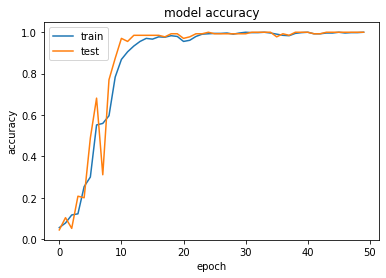

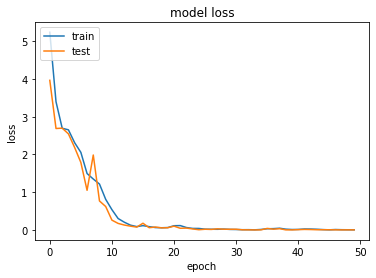

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
my_model.save('/content/drive/My Drive/my_model.h5')

In [ ]:
from keras.models import load_model

model = load_model('/content/drive/My Drive/my_model.h5')

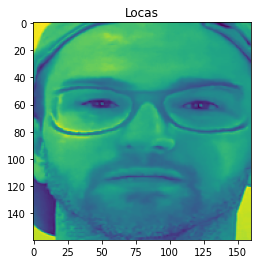

In [ ]:
from random import choice
# select a random face from test set
selection = choice([i for i in range(x_test.shape[0])])
random_face = x_test[selection]

model_out=model.predict(x_test)[selection]
if(len(random_face .shape) == 3):
    plt.imshow(np.squeeze(random_face))
elif(len(random_face .shape) == 2):
    plt.imshow(random_face )
else:
    print("Higher dimensional data")

plt.title(image_class)
plt.show()    